# Projet PAO : réalisation d'un réseau de neurone pour de l'apprentissage supervisé

Dans le cadre d'un projet d'approfondissement personnel sur le langage Python et l'utilisation de ses librairies, nous avons été amenés à réaliser un premier projet de deep learning

In [1]:
import pandas as pd
from scipy.io import loadmat
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from keras.preprocessing import image
import seaborn as sns
import gc
from tensorflow.keras.models import load_model

## Import des données

In [2]:
list_and_labels = loadmat("./lists/train_list.mat")
list_and_labels_test = loadmat("./lists/test_list.mat")

Mes données sont des images de différentes races de chien. L'objectif de ce modèle est de pouvoir déterminer quel est la race du chien présenté en image. 

## Analyse du dataset

In [3]:
print("taille des données d'entrainement : ", list_and_labels['labels'].shape[0])
print("taille des données de test : ", list_and_labels_test['labels'].shape[0])

taille des données d'entrainement :  12000
taille des données de test :  8580


les données d'entrainement sont au nombre de 12000, on possède 120 races de chiens. Et après analyse du dataset, on possède 100 images d'entrainement pour chaque classe. Après plusieurs tentatives de chargement des données, j'ai remarqué que charger 12000 images en mémoire pouvait être compliqué pour ma machine, j'ai donc décidé de reduire le nombre de classe sur lesquelles j'allais réaliser mon projet. Pour cela j'ai choisi les classes ayant le plus de données.

In [4]:
listeClasse =["Maltese_dog","Afghan_hound","Scottish_deerhound","Pomeranian","Samoyed","Bernese_mountain_dog","Irish_wolfhound","Shih-Tzu","Great_Pyrenees","Leonberg","basenji","Tibetan_terrier","EntleBucher","Airedale","Sealyham_terrier","pug","Saluki","cairn","Siberian_husky","Ibizan_hound","Blenheim_spaniel","whippet","bloodhound","Lhasa","Norwich_terrier","Japanese_spaniel","miniature_pinscher","silky_terrier","Boston_bull"]

In [5]:
def SelectionDesDonnées(listeClasse,types):
    if types=='train' :
        fichier = list_and_labels
    else :
        if types=='test':
            fichier = list_and_labels_test
        else : 
            return 'erreur'
    label = 0
    df = pd.DataFrame(columns=['image', 'label'])
    img_chemin = "./images/Images/"

    for NameClasse in listeClasse :
        temp = pd.DataFrame(columns=['image', 'label'])
        #print(NameClasse)
        temp['image'] = [img_chemin + i[0][0] for i in fichier['file_list'] if NameClasse in i[0][0]]
        temp['label'] = label
        label +=1
        df = df.append(temp)
        del(temp)
    return df

In [6]:
dfTrain =  SelectionDesDonnées(listeClasse,'train')
print('nouvelle taille des données d''entrainement',dfTrain.shape)

nouvelle taille des données dentrainement (2900, 2)


In [7]:
dfTest = SelectionDesDonnées(listeClasse,'test')
print('nouvelle taille des données de test',dfTest.shape)

nouvelle taille des données de test (2998, 2)


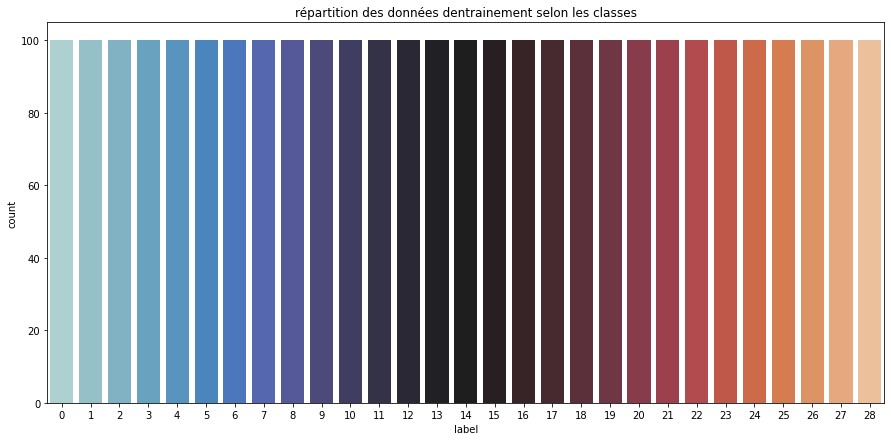

In [8]:
dfTrain['label'].value_counts(dropna=False)
plt.figure(figsize=(15,7))
plt.title('répartition des données d''entrainement selon les classes')
g = sns.countplot(dfTrain['label'], palette="icefire")

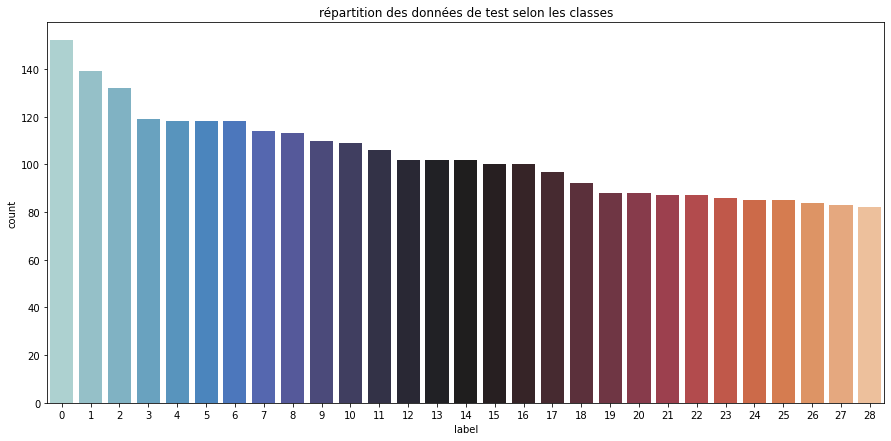

In [9]:
dfTest['label'].value_counts(dropna=False)
plt.figure(figsize=(15,7))
plt.title('répartition des données de test selon les classes')
g = sns.countplot(dfTest['label'], palette="icefire")

### Visualisation des données et chargement des images

In [10]:
def read_img(chemin, size):    
    img = image.load_img(chemin, target_size=size)
    img = image.img_to_array(img)
    return img

IMG_SIZE = 128

#### Images d'entrainements

In [11]:
X_train = np.zeros((len(dfTrain), IMG_SIZE, IMG_SIZE, 3), dtype='float32')
index = 0
for i in dfTrain['image'] :
    img = read_img(i,(IMG_SIZE, IMG_SIZE))
    x = np.expand_dims(img.copy(), axis=0)
    X_train[index] = x / 255.0
    index+=1
Y_train = dfTrain['label'].to_numpy()

pour économiser de la RAM

In [12]:
del(dfTrain)
del(list_and_labels)
del(list_and_labels_test)
gc.collect()

5451

#### Images de Test

In [13]:
X_test = np.zeros((len(dfTest), IMG_SIZE, IMG_SIZE, 3), dtype='float32')
index = 0
for i in dfTest['image'] :
    img = read_img(i,(IMG_SIZE, IMG_SIZE))
    x = np.expand_dims(img.copy(), axis=0)
    X_test[index] = x / 255.0
    index+=1
Y_test = dfTest['label'].to_numpy(dtype = int)

In [14]:
del(dfTest)
gc.collect()

40

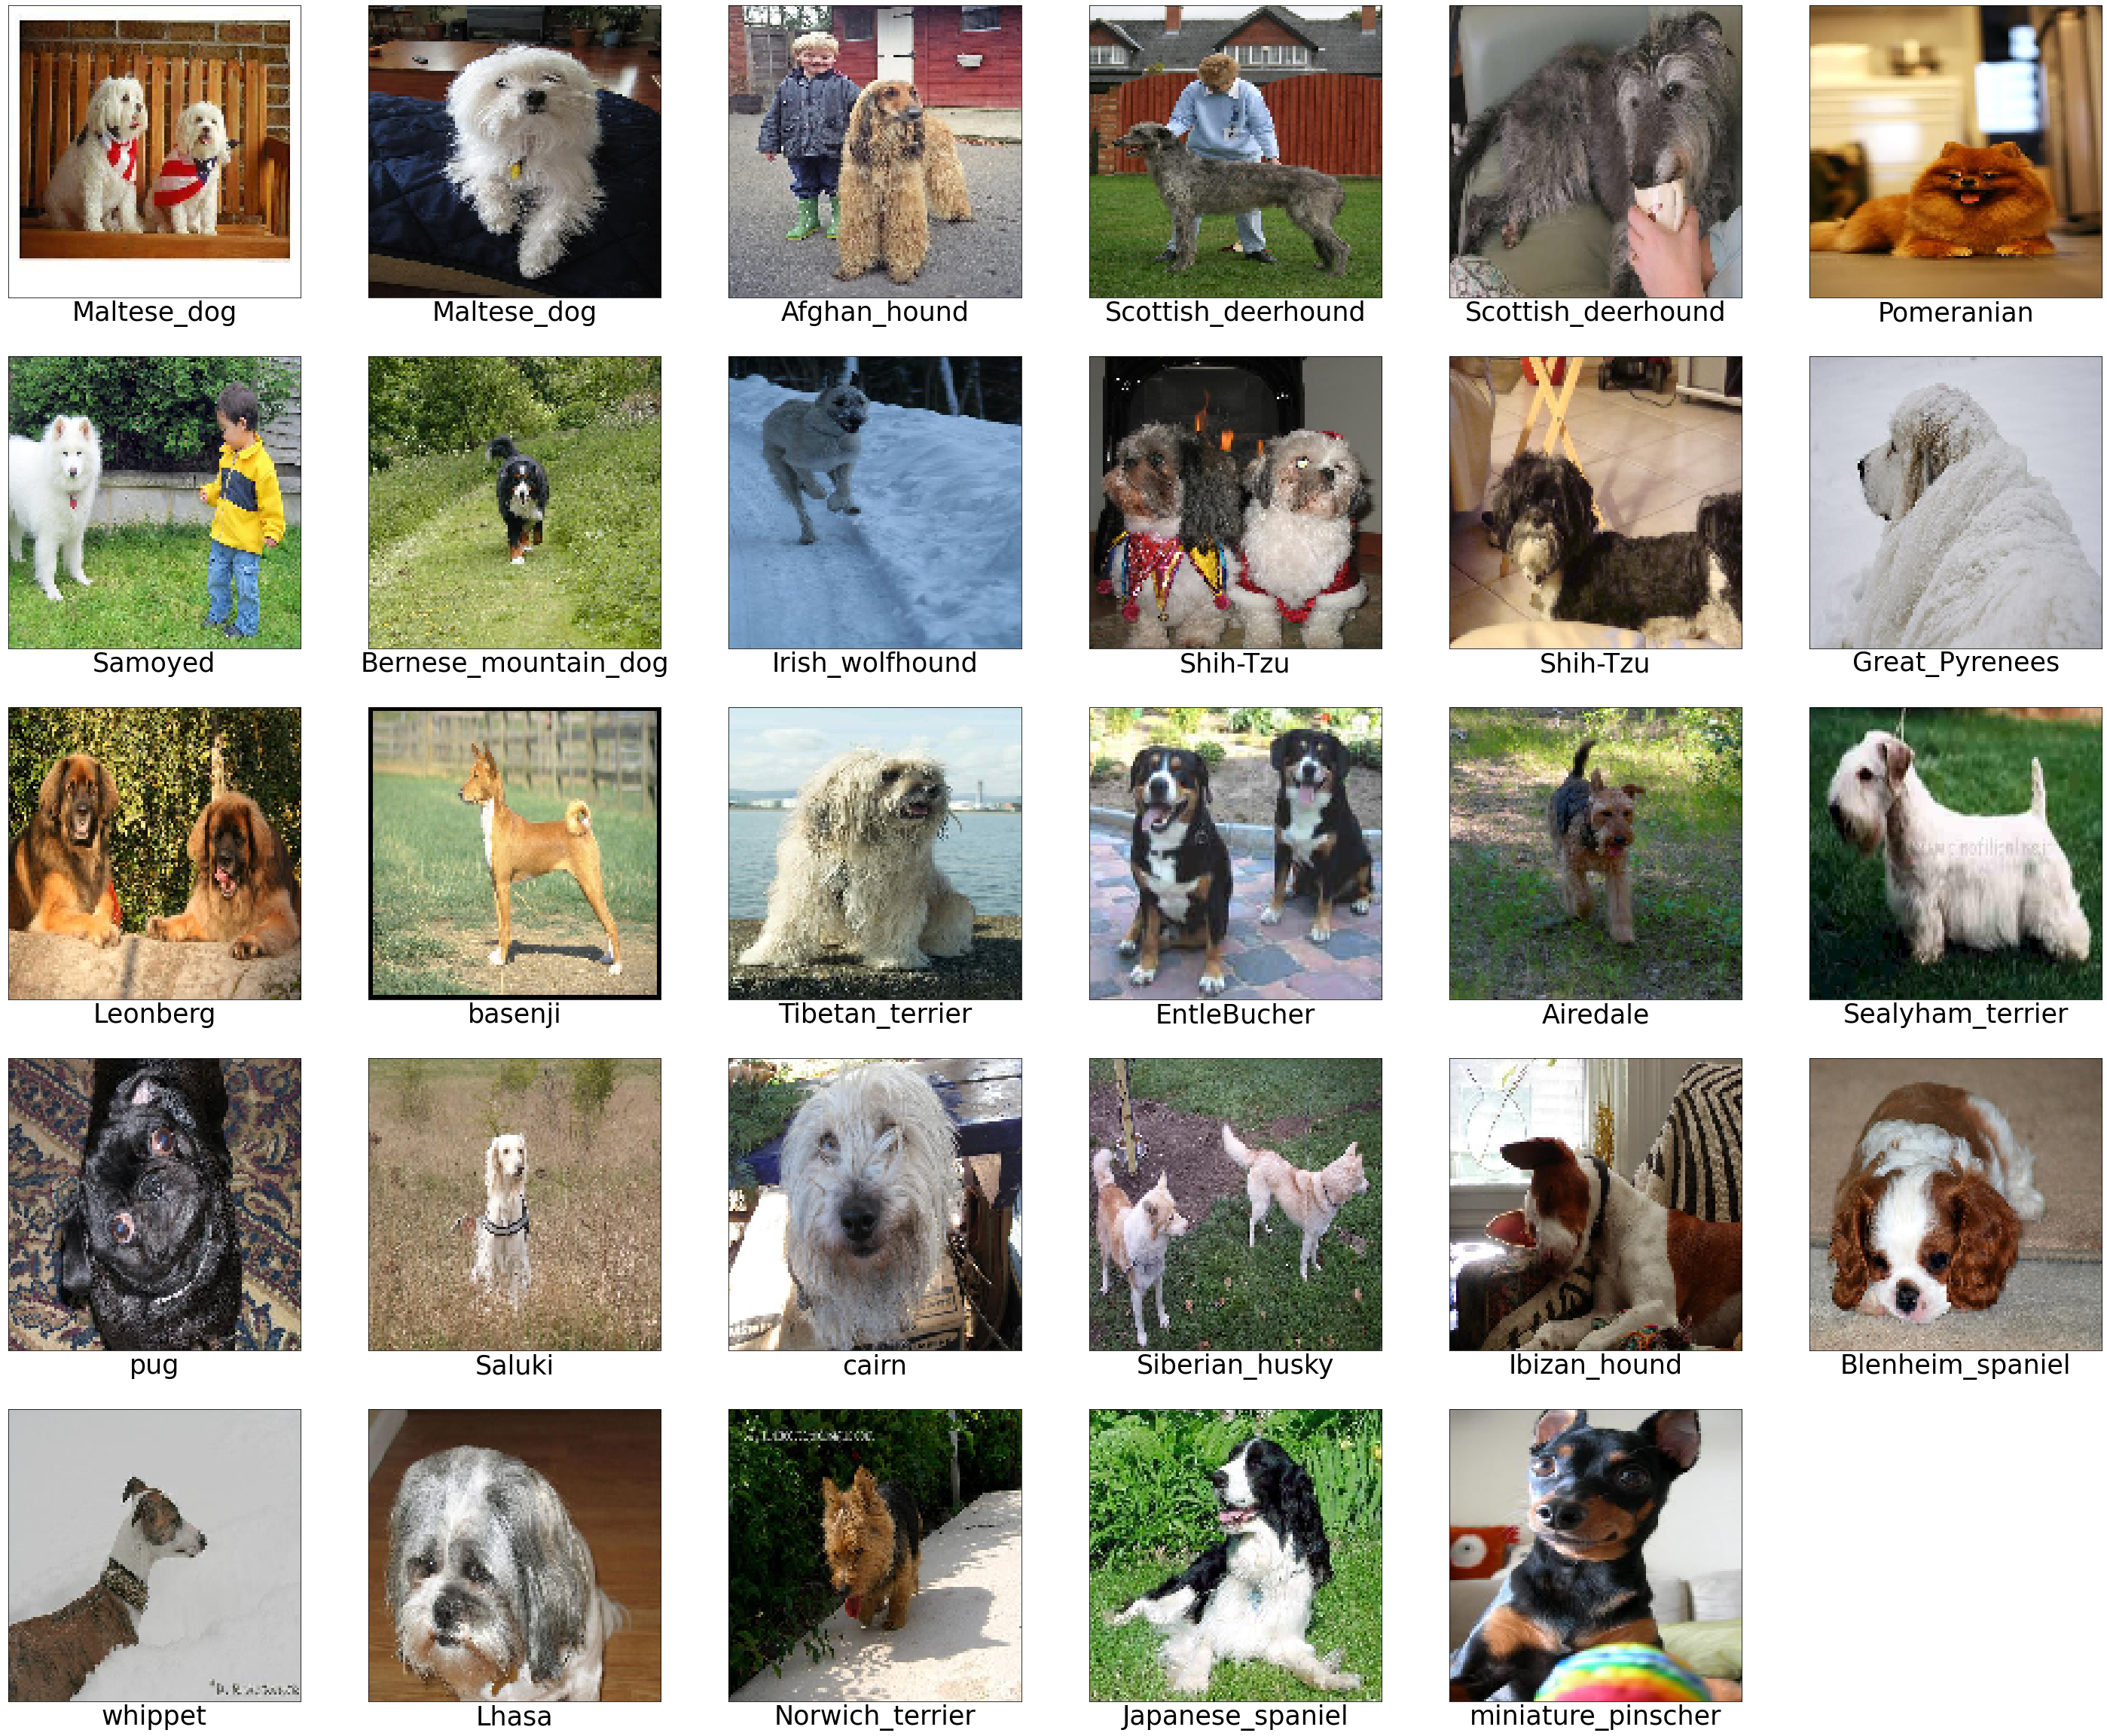

In [15]:
plt.figure(figsize=(50,50))
j=1
for i in np.arange(0,2900,100):
    plt.subplot(6,6,j)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    plt.xlabel(listeClasse[Y_test[i]],size=35)
    j+=1
plt.show()

Les images du dataset sont très variées, en effet, les chiens sont sur des fonds différents, ils sont par moment accompagnés de d'humain, ils sont aussi plusieurs sur certaines photos et par moment sont aussi habillés ! Ainsi on peut sentir qu'un simple réseaux de neurones apprenant sur 100 images ne sera pas suffisant afin de classifier les images de manières efficace. On se rend compte de la complexité du dataset.

In [15]:
X_train = np.asanyarray(X_train).astype('float32')
Y_train = np.asanyarray(Y_train).astype('int')
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, shuffle=True, test_size=0.2,stratify=Y_train)

## Transfer Learning

Après plusieurs essaies, les réseaux de neurones que j'ai mis en plus ne permettaient pas une classification efficace. J'ai donc décidé (en vue de mon nombre de donnée d'apprentissage faible) de me tourner vers du Transfer Learning basé sur le dataset "imageNet"

In [16]:
from keras.applications import VGG16

# include top should be False to remove the softmax layer
pretrained_model = VGG16(include_top=False, weights='imagenet',pooling='avg')
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### features extractions

In [17]:
import pickle

In [30]:
vgg_features_train = pretrained_model.predict(X_train)
vgg_features_val = pretrained_model.predict(X_val)
vgg_features_test = pretrained_model.predict(X_test)

In [31]:
fileTrain = open( "./modele/vgg_feature_train.pkl", "wb" )
fileTest = open( "./modele/vgg_feature_test.pkl", "wb" )
fileVal = open( "./modele/vgg_feature_val.pkl", "wb" )
pickle.dump(vgg_features_train, fileTrain )
fileTrain.close()
pickle.dump(vgg_features_test, fileTest )
fileTest.close()
pickle.dump(vgg_features_val, fileVal )
fileVal.close()

In [18]:
#vgg_features_train = pickle.load( open( "./modele/vgg_feature_train.pkl", "rb" ) )
#vgg_features_test = pickle.load( open( "./modele/vgg_feature_test.pkl", "rb" ) )
#vgg_features_val = pickle.load( open( "./modele/vgg_feature_val.pkl", "rb" ) )

In [32]:
from keras.utils import to_categorical

train_target = to_categorical(Y_train)
val_target = to_categorical(Y_val)
test_target = to_categorical(Y_test)

### construction du réseaux de neurones

In [33]:
model2 = models.Sequential()
model2.add(layers.Flatten())
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.BatchNormalization())
model2.add(layers.Dense(29, activation='softmax'))
model2.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

### Entrainement du modèle

Lors du l'entrainement du modèle je me suis rendue compte que l'accuracy la plus élévée n'était pas forcement celle obtenue à la fin. J'ai donc enregistré le modèle donnant la meilleure accuracy lors de l'entrainement. C'est ce modèle qui nous permettra de faire nos tests

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint
save_at = "./modele/model.hdf5"
save_best = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

In [35]:
history = model2.fit(vgg_features_train, train_target, epochs=50, batch_size=128, validation_data=(vgg_features_val, val_target),callbacks = [save_best])

Epoch 1/50
19/19 [==============================] - 1s 27ms/step - loss: 3.6823 - accuracy: 0.0388 - val_loss: 3.4713 - val_accuracy: 0.0345
Epoch 2/50
19/19 [==============================] - 0s 17ms/step - loss: 3.4056 - accuracy: 0.0724 - val_loss: 3.3136 - val_accuracy: 0.0586
Epoch 3/50
19/19 [==============================] - 0s 19ms/step - loss: 3.2291 - accuracy: 0.1017 - val_loss: 3.2349 - val_accuracy: 0.1138
Epoch 4/50
19/19 [==============================] - 0s 26ms/step - loss: 3.0469 - accuracy: 0.1431 - val_loss: 3.1888 - val_accuracy: 0.1621
Epoch 5/50
19/19 [==============================] - 0s 20ms/step - loss: 2.9492 - accuracy: 0.1547 - val_loss: 3.1416 - val_accuracy: 0.1862
Epoch 6/50
19/19 [==============================] - 0s 21ms/step - loss: 2.8674 - accuracy: 0.1849 - val_loss: 3.1128 - val_accuracy: 0.1931
Epoch 7/50
19/19 [==============================] - 0s 17ms/step - loss: 2.7750 - accuracy: 0.2190 - val_loss: 3.0671 - val_accuracy: 0.2155
Epoch 8/50
19

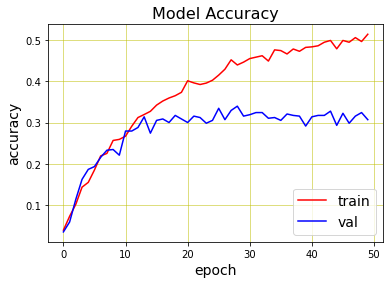

In [36]:
plt.plot()
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.legend(['train', 'val'], loc='lower right', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

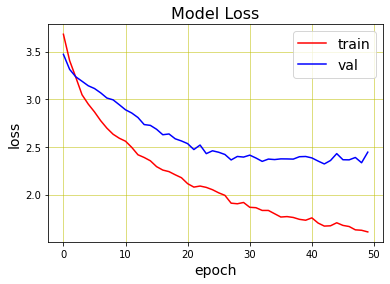

In [37]:
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss', fontsize=16)
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.legend(['train', 'val'], loc='upper right', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')

### Evaluation du modèle

In [38]:
bestModel = load_model('./modele/model.hdf5')

In [39]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [40]:
score = bestModel.evaluate(vgg_features_test, test_target)

94/94 [==============================] - 1s 6ms/step - loss: 2.3350 - accuracy: 0.3339


le modèle présente un score de 32%, pour un dataset de 29 classes ce score semble tout à fait raisonnable. Néanmoins, regardons la matrice de confusion afin de visualiser les prédictions selon les classes

In [41]:
Yvect_test_target= np.zeros(test_target.shape[0])
for i in range(len(Yvect_test_target)) :
    Yvect_test_target[i] = np.argmax(test_target[i]) 

In [42]:
y_pred1 = bestModel.predict(vgg_features_test)
Yvect_test_pred = np.zeros(test_target.shape[0])
for i in range(len(Yvect_test_pred)) :
    Yvect_test_pred[i] = np.argmax(y_pred1[i]) 

In [43]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize = (75,75))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    cbar = plt.colorbar(orientation="horizontal",fraction=0.05, pad=0.075)
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(50)
    tick_marks = np.arange(len(listeClasse))
    plt.xticks(tick_marks, listeClasse, rotation=90,size=50)
    plt.yticks(tick_marks, listeClasse,size=50)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

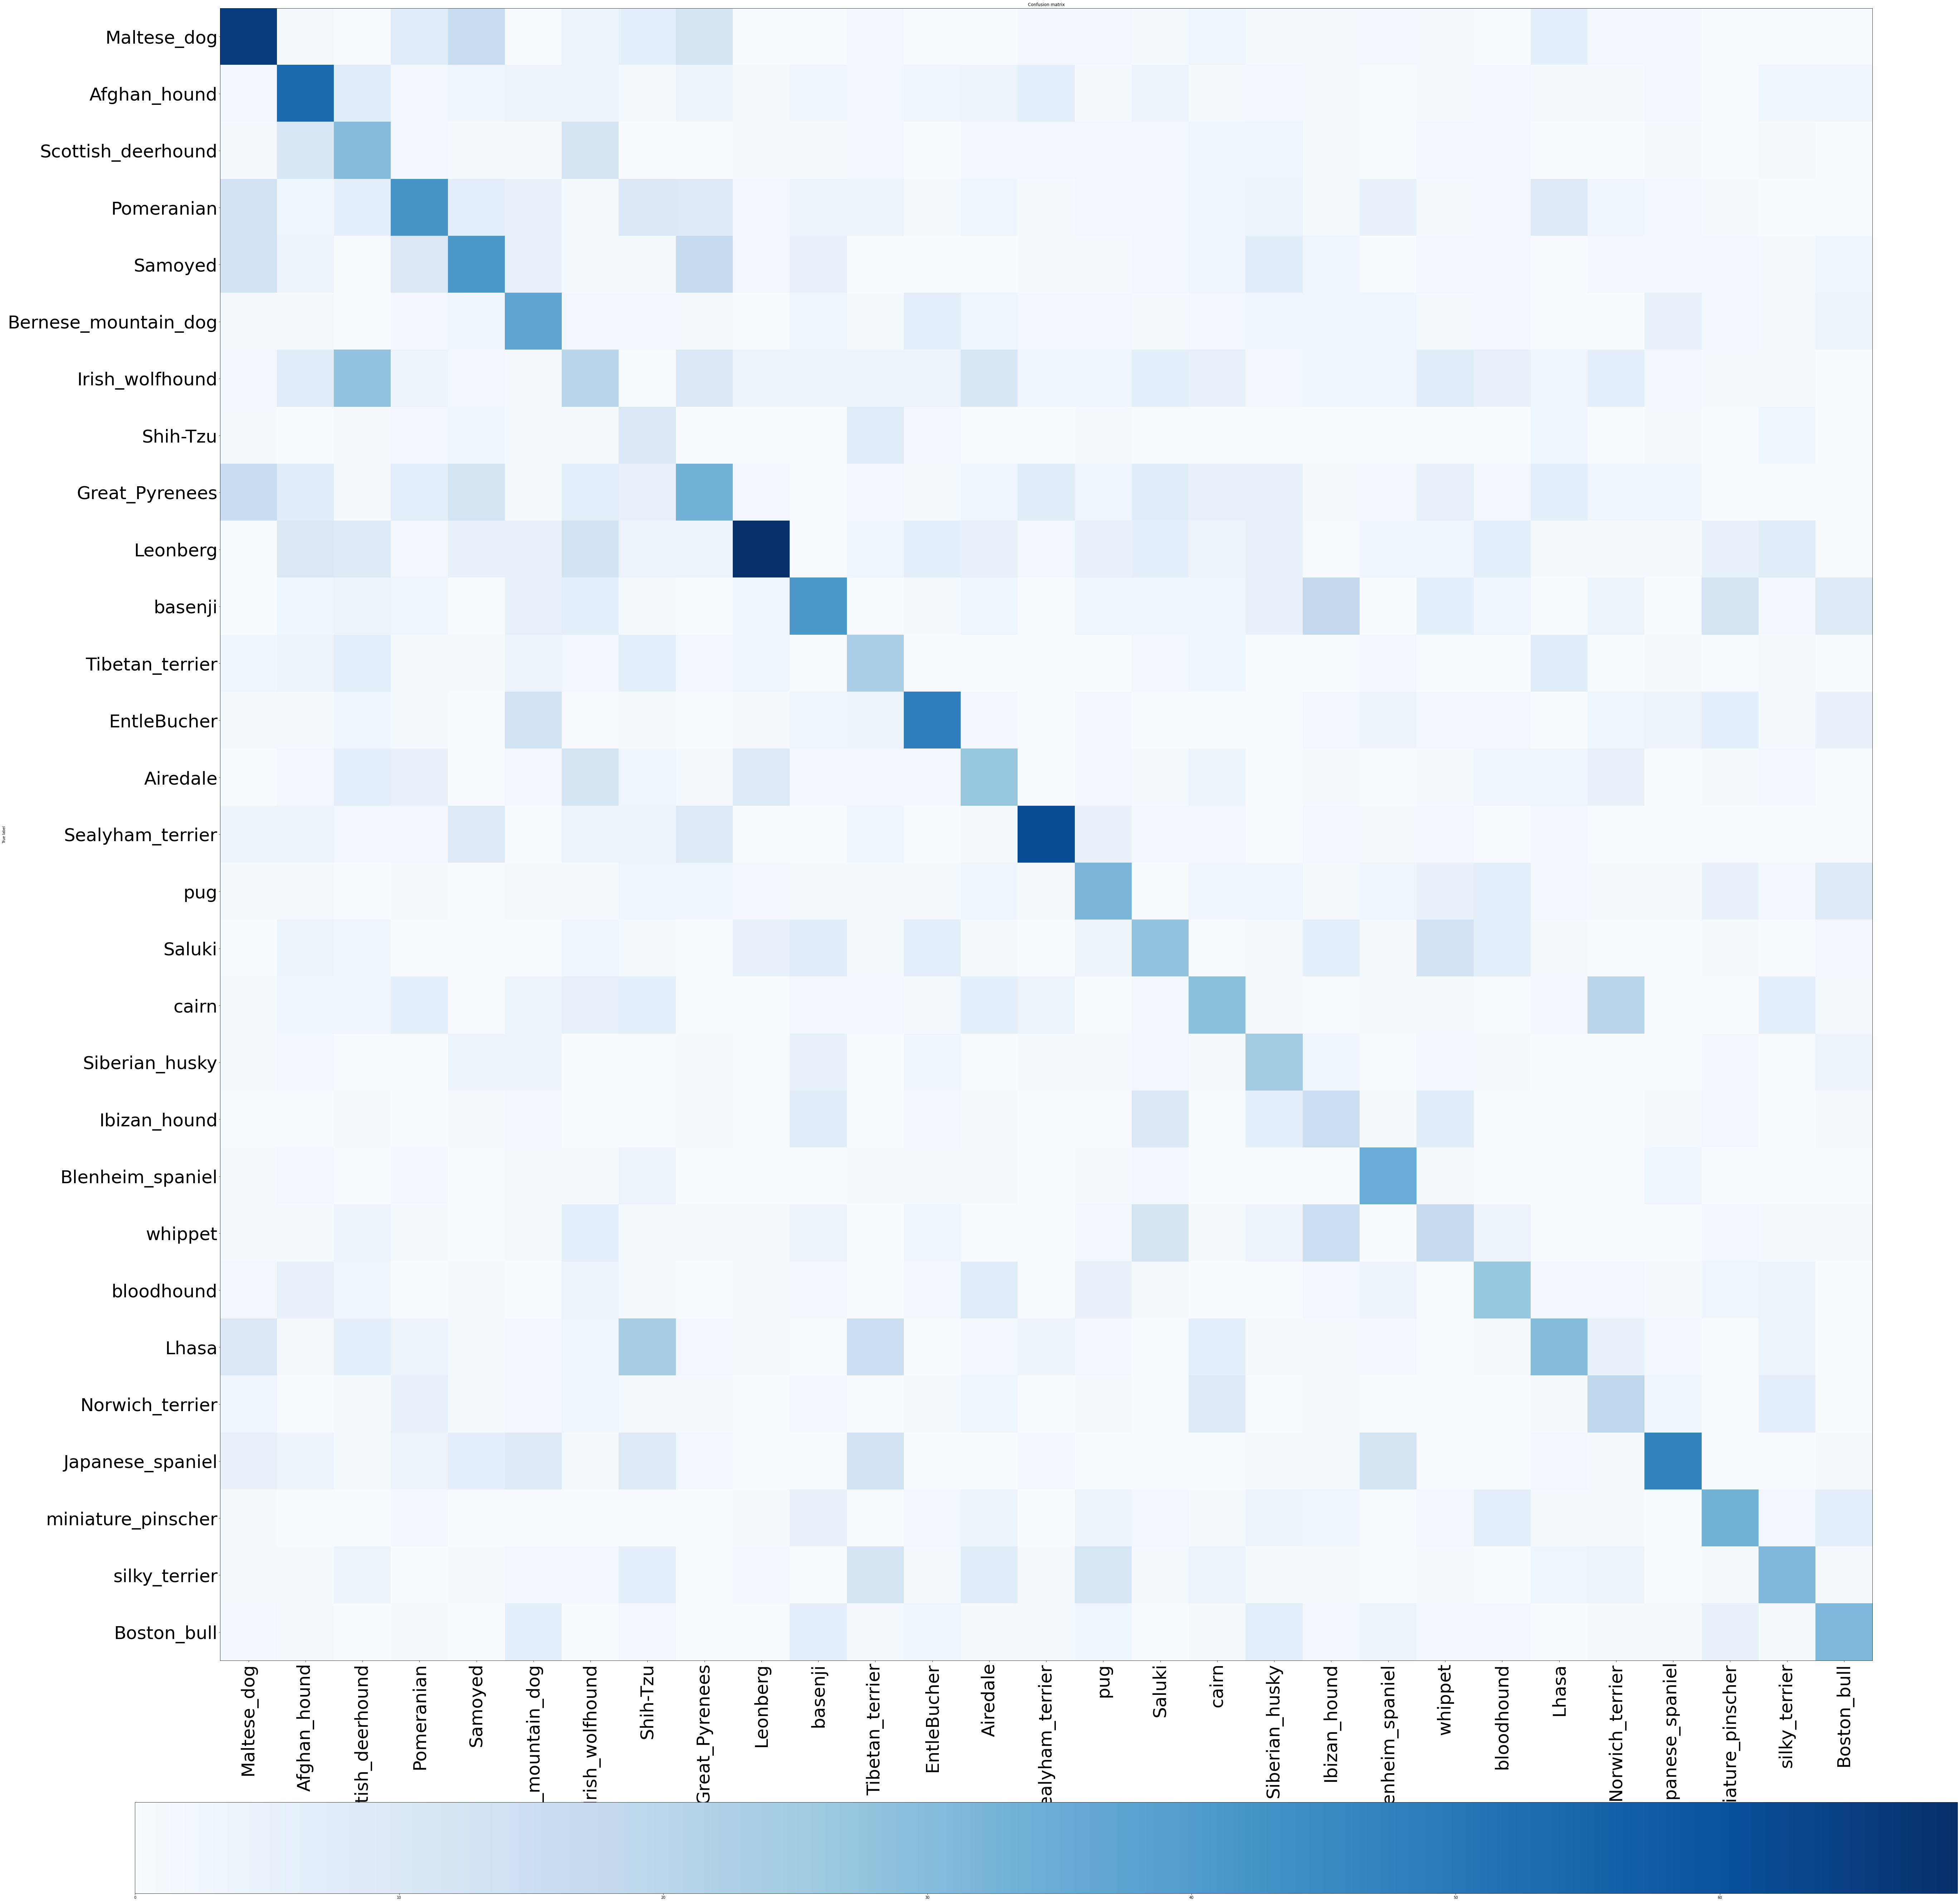

In [44]:
plot_confusion_matrix(confusion_matrix(Yvect_test_pred, Yvect_test_target))

On voit plutot bien se dessiner la diagonale de la matrice de confusion. Cela nous indique que certaines classes sont plutôt bien distincts les unes des autres. Notamment, les classes les plus foncées : Maltese_dog, Samoyed, Airedale, sont des classes qui sont bien determinées par le modèle

## Conclusion

Ce projet m'a permis de me familiariser avec le domaine du Deep Learning, cette première approche reste néanmoins difficile sans base théorique sur le fonctionnement des modèles et même des réseaux de neurones. Dans le cadre de l'EC, ce projet m'a permis de revoir et d'appliquer les notions abordées en classe, gestion des calculs avec numpy, gestion des images et des graphes avec matplotlib et d'autres librairies notamment keras

### Piste d'amélioration
utilisation de SVM pour la classification

In [30]:
from sklearn import svm

In [31]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
C = np.arange(1,10,0.5)
gamma = np.arange(1e-9, 1e-7,1e-8)
parameters = {'kernel': ('linear', 'rbf','poly'), 'C':C ,'gamma': gamma}
svc = svm.SVC()
clf = RandomizedSearchCV(svc, parameters,n_jobs=-1)
clf.fit(mn_train_features, Y_train)

In [ ]:
clf.best_params_

In [ ]:
regressorGridSearch=svm.SVC(C= 2.0, gamma = 1.1000000000000001e-08,kernel='linear')
regressorGridSearch.fit(vgg_features_train,Y_train)
pred=regressorGridSearch.predict(vgg_features_test)

In [ ]:
plot_confusion_matrix(confusion_matrix(pred.T, Y_test))

In [ ]:
print(f1_score(Y_test, pred , average="macro"))

In [ ]:
print(classification_report(Y_test, pred))

In [48]:
mnet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                     include_top=False, weights='imagenet',pooling='avg')

In [49]:
from tqdm.notebook import tqdm
def img_feature_extraction(x_values, pre_model):

    data = []
    
    # preprocessing and then using pretrained neural nets to extract features to be fed into Global Pooling
    for image in tqdm(x_values):
        im_toarray = tf.keras.preprocessing.image.img_to_array(image)
        
        im_toarray = np.expand_dims(image, axis=0)
        im_toarray = tf.keras.applications.mobilenet.preprocess_input(im_toarray)
        
        data.append(im_toarray)
        
    data_stack = np.vstack(data) 
    
    features = pre_model.predict(data_stack, batch_size=32)
    
    return data_stack, features

In [ ]:
trainX_proc, mn_train_features = img_feature_extraction(X_train, mnet_model)
valX_proc, mn_val_features = img_feature_extraction(X_val, mnet_model)